## Importing all the required Libraries

In [2]:
# Standard Library Imports
import math
import time
import subprocess
from datetime import datetime

# Third-Party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from numpy import newaxis
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, History
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import (
    Dense,
    LSTM,
    SimpleRNN,
    Dropout,
    Bidirectional,
    Activation,
)

In [2]:
stock_data = pd.read_csv('ITC.NS.csv')

In [3]:
stock_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Dropping all the rows with nan values
stock_data.dropna(inplace=True)

# Printing df
stock_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-02,134.566666,134.566666,131.933334,132.433334,98.812592,2860839.0
1,2012-01-03,133.233337,134.366669,132.866669,133.566666,99.658203,6065590.0
2,2012-01-04,134.333328,134.466660,132.333328,133.033340,99.260269,11875083.0
3,2012-01-05,132.699997,133.333328,131.733337,133.199997,99.384613,11364489.0
4,2012-01-06,132.699997,135.399994,132.233337,134.733337,100.528709,8788212.0
...,...,...,...,...,...,...,...
2714,2022-12-26,326.500000,335.100006,325.500000,334.600006,329.405029,9566210.0
2715,2022-12-27,335.600006,336.399994,330.149994,333.149994,327.977539,6727343.0
2716,2022-12-28,332.850006,335.000000,331.500000,334.399994,329.208130,7737562.0
2717,2022-12-29,334.350006,335.750000,331.549988,335.350006,330.143372,8105359.0


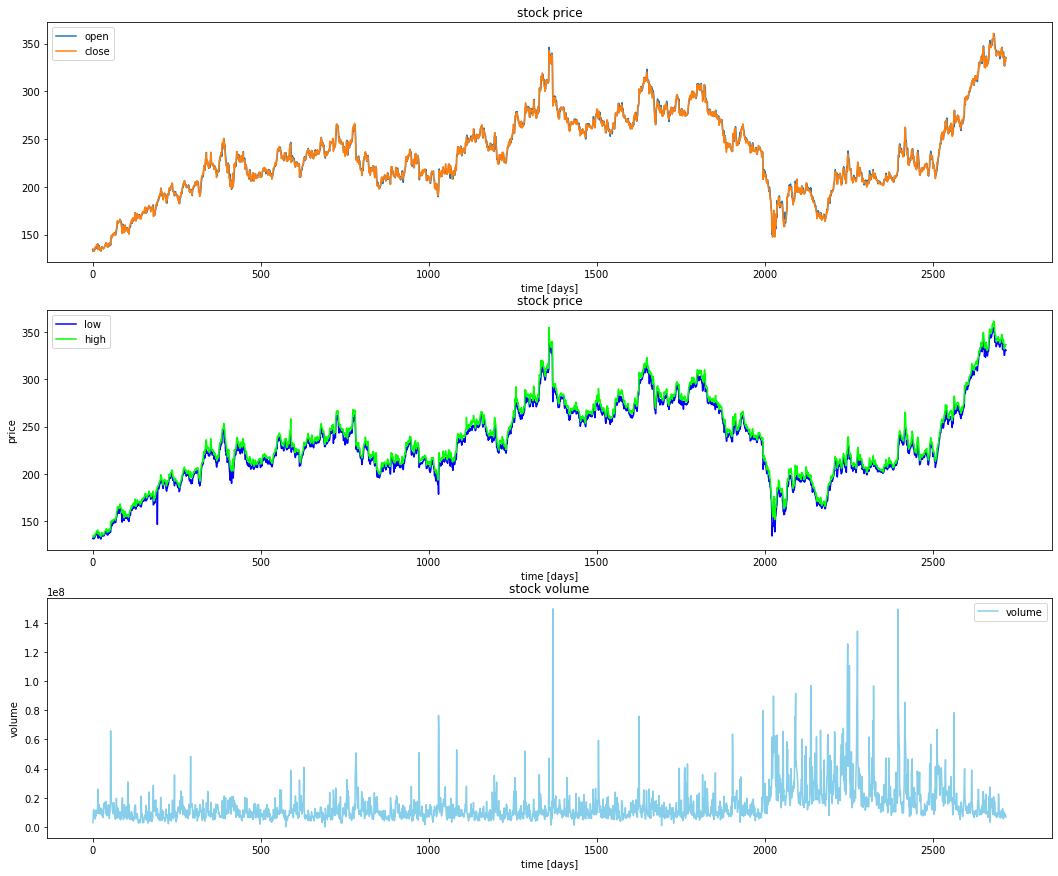

In [4]:
plt.figure(figsize=(18,15));
plt.subplot(3,1,1)
plt.plot(stock_data['Open'], label='open')
plt.plot(stock_data['Close'], label='close')
#plt.gca().invert_xaxis()
plt.title('stock price')
plt.xlabel('time [days]')
plt.legend(loc='best')

plt.subplot(3,1,2)
plt.plot(stock_data['Low'], color='blue', label='low')
plt.plot(stock_data['High'], color='lime', label='high')
#plt.gca().invert_xaxis()
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(3,1,3)
plt.plot(stock_data['Volume'], color='skyblue', label='volume')
#plt.gca().invert_xaxis()
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
     

In [6]:
close_prices= stock_data.filter(['Close']) #creates a dataframe just with specified column( close )
values = close_prices.values
training_data_len = math.ceil(len(values) * 0.8)

In [7]:
scaled_data=scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len,:]

In [8]:
window_size = 60
x_train=[]
y_train=[]
for i in range(window_size,len(train_data)):
  x_train.append(train_data[i-window_size:i,0])
  y_train.append(train_data[i,0])
     

In [9]:
x_train,y_train=np.array(x_train),np.array(y_train)


In [10]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [11]:
test_data = scaled_data[training_data_len - window_size: , :]
x_test=[]
y_test= values[training_data_len:]
for j in range(window_size,len(test_data)):
  x_test.append(test_data[j-window_size:j,0])

x_test=np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [12]:
len(x_test),len(x_train)

(542, 2111)

In [13]:
len(y_test),len(y_train)

(542, 2111)

In [14]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2111, 60, 1)
y_train.shape =  (2111,)
x_test.shape =  (542, 60, 1)
y_test.shape =  (542, 1)


In [15]:
#MODEL 1
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(x_train, y_train,epochs=50, batch_size=32 , validation_split=0.25,  verbose=1 , shuffle=True)


Epoch 1/50
50/50 [==============================] - 5s 58ms/step - loss: 0.0121 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 2/50
50/50 [==============================] - 2s 43ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 3/50
50/50 [==============================] - 2s 43ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 4/50
50/50 [==============================] - 2s 44ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 5/50
50/50 [==============================] - 2s 44ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 6/50
50/50 [==============================] - 2s 44ms/step - loss: 9.6717e-04 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 7/50
50/50 [==============================] - 2s 44ms/step - loss: 9.6836e-04 - accuracy: 0.0000

In [17]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

17/17 [==============================] - 1s 12ms/step


In [18]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
mse = np.mean(predictions - y_test)**2
from sklearn.metrics import r2_score
#R2 = r2_score(y_test, predictions, multioutput='variance_weighted')
print('RMSE : ',rmse)
print('MSE : ',mse)
#print('R2 : ',R2)

RMSE :  0.9734460508983652
MSE :  0.9475972140096226


In [19]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, predictions)
print(mape)

0.011879848181026324


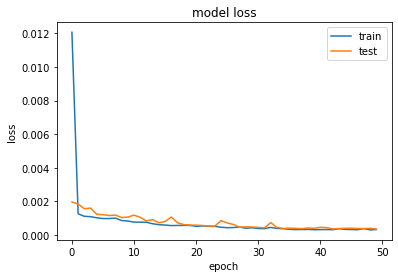

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


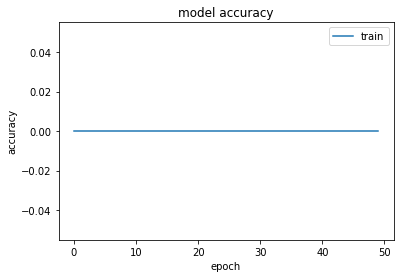

In [21]:
from keras.models import Sequential
from keras.layers import Dense

# list all data in history
print(history.history.keys())

# summarize history for accuracy

plt.size=(10,5)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [22]:
training_data_len
     

2171

C:\Users\DELL\AppData\Local\Temp\ipykernel_9728\3648870739.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = predictions


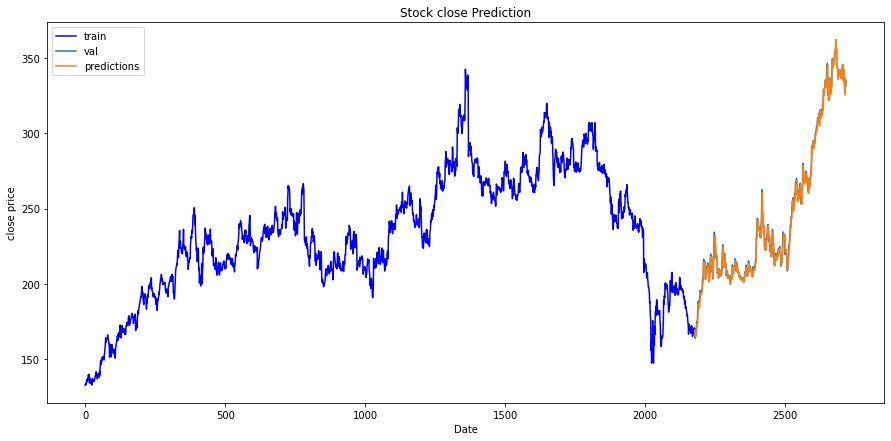

In [23]:
data1 = stock_data.filter(['Close'])
train= data1[:training_data_len]
validation = data1[training_data_len:]
validation['predictions'] = predictions

plt.figure(figsize=(15, 7))
plt.title('Stock close Prediction')
plt.xlabel('Date')
plt.ylabel('close price')
plt.plot(train, color='blue')
plt.plot(validation[['Close','predictions']])
plt.legend(['train','val','predictions'],loc='upper left')
plt.show()
     

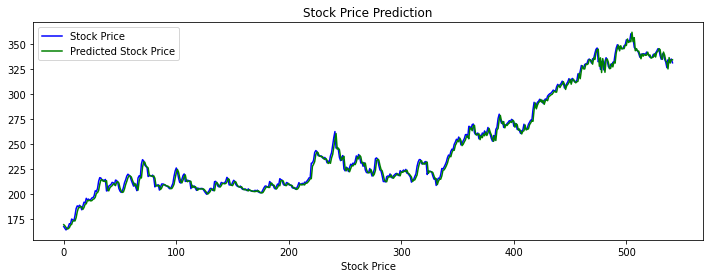

In [24]:
plt.figure(figsize=(12, 4))

real_stock_price = y_test[:]
plt.plot(real_stock_price, color='blue', label='Stock Price')
plt.plot(predictions, color='green', label='Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.xlabel('Stock Price')
plt.legend()
plt.show()

In [25]:
len(y_test)

542

In [26]:
len(x_test)

542

In [27]:
fut_inp = x_test[442:] #taking 100 features as the future input

In [28]:
fut_inp = fut_inp.reshape(1,-1)

In [29]:
tmp_inp = list(fut_inp)


In [30]:
fut_inp.shape

(1, 6000)

In [31]:
tmp_inp = tmp_inp[0].tolist()


In [32]:
# Prediting the future closing prices.....here i am predicting for the next 62 days
lst_output=[]
n_steps=6000
i=0
while(i<62):
    
    if(len(tmp_inp)>6000):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.8858307600021362], [0.882392942905426], [0.8799739480018616], [0.8784245848655701], [0.8773981332778931], [0.8765565752983093], [0.8756908774375916], [0.8747146129608154], [0.8736171722412109], [0.8724204897880554], [0.8711510896682739], [0.8698289394378662], [0.8684657216072083], [0.8670675158500671], [0.8656370639801025], [0.864176869392395], [0.862689733505249], [0.8611787557601929], [0.8596479296684265], [0.8581010103225708], [0.8565418720245361], [0.8549740314483643], [0.8534008264541626], [0.8518250584602356], [0.8502494692802429], [0.8486760854721069], [0.8471069931983948], [0.8455435633659363], [0.8439868688583374], [0.8424376845359802], [0.8408967852592468], [0.8393643498420715], [0.8378404378890991], [0.8363248705863953], [0.8348174691200256], [0.8333178758621216], [0.8318251967430115], [0.8303390741348267], [0.8288585543632507], [0.8273833394050598], [0.8259121775627136], [0.8244443535804749], [0.8229791522026062], [0.8215160369873047], [0.8200541734695435], [0.818592965

In [33]:
import array as arr
a=np.array(lst_output)
print(a)

[[0.88583076]
 [0.88239294]
 [0.87997395]
 [0.87842458]
 [0.87739813]
 [0.87655658]
 [0.87569088]
 [0.87471461]
 [0.87361717]
 [0.87242049]
 [0.87115109]
 [0.86982894]
 [0.86846572]
 [0.86706752]
 [0.86563706]
 [0.86417687]
 [0.86268973]
 [0.86117876]
 [0.85964793]
 [0.85810101]
 [0.85654187]
 [0.85497403]
 [0.85340083]
 [0.85182506]
 [0.85024947]
 [0.84867609]
 [0.84710699]
 [0.84554356]
 [0.84398687]
 [0.84243768]
 [0.84089679]
 [0.83936435]
 [0.83784044]
 [0.83632487]
 [0.83481747]
 [0.83331788]
 [0.8318252 ]
 [0.83033907]
 [0.82885855]
 [0.82738334]
 [0.82591218]
 [0.82444435]
 [0.82297915]
 [0.82151604]
 [0.82005417]
 [0.81859297]
 [0.81713164]
 [0.81567019]
 [0.81420785]
 [0.81274402]
 [0.81127864]
 [0.80981171]
 [0.80834281]
 [0.80687165]
 [0.8053984 ]
 [0.80392283]
 [0.80244488]
 [0.80096477]
 [0.79948246]
 [0.79799813]
 [0.79651183]
 [0.79502356]]


In [34]:
#printing the predicted values and storing them in array
b=scaler.inverse_transform(lst_output)
print(b)

[[334.63897886]
 [333.85423977]
 [333.30206384]
 [332.94839586]
 [332.71409117]
 [332.52199152]
 [332.32438155]
 [332.1015329 ]
 [331.85102375]
 [331.57786102]
 [331.28809927]
 [330.98629643]
 [330.67511923]
 [330.35595544]
 [330.02943095]
 [329.69611718]
 [329.35665361]
 [329.01174774]
 [328.66231115]
 [328.30920101]
 [327.95330169]
 [327.59541593]
 [327.23630566]
 [326.87661033]
 [326.51695582]
 [326.15780473]
 [325.79963325]
 [325.44275431]
 [325.08741283]
 [324.73378567]
 [324.38204971]
 [324.03224577]
 [323.68438745]
 [323.33843394]
 [322.99434441]
 [322.65203724]
 [322.31130834]
 [321.97207607]
 [321.63412274]
 [321.29738032]
 [320.96156309]
 [320.62650779]
 [320.29205114]
 [319.95807069]
 [319.62437596]
 [319.29083089]
 [318.95725862]
 [318.62365913]
 [318.28985555]
 [317.95571183]
 [317.62121436]
 [317.28636315]
 [316.95106294]
 [316.61524571]
 [316.27895228]
 [315.94212823]
 [315.60475995]
 [315.26690186]
 [314.92854036]
 [314.58971626]
 [314.25044317]
 [313.91072109]]


In [35]:
len(scaled_data)

2713

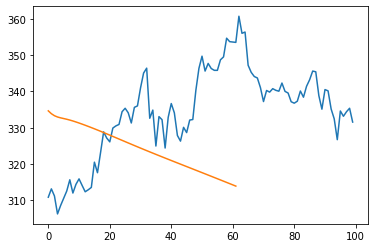

In [36]:
#plotting the new predicted values
plt.plot(scaler.inverse_transform(scaled_data[2613:]))
plt.plot(scaler.inverse_transform(lst_output))

In [37]:
ds_new = scaled_data.tolist()

In [38]:
len(ds_new)

2713

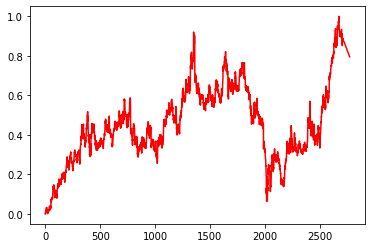

In [39]:
ds_new.extend(lst_output)
plt.plot(ds_new,color='red')

In [40]:
final_graph = scaler.inverse_transform(ds_new).tolist()

No handles with labels found to put in legend.


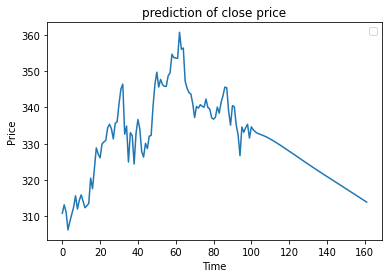

In [42]:
plt.plot(final_graph[2613:])
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("prediction of close price")
plt.legend()